In [1]:
import math
from typing import Any

import numpy as np
import torch
from diffusers import StableDiffusion3Pipeline
from diffusers.models.attention_processor import Attention, JointAttnProcessor2_0
from ncut_pytorch import rgb_from_cosine_tsne_3d
from PIL import Image
from sd3_lora_celeba.visualization import TextTokenAndImageVisualizer

In [2]:
def joint_attn_processor_call(
    self: JointAttnProcessor2_0,
    attn: Attention,
    hidden_states: torch.FloatTensor,
    encoder_hidden_states: torch.FloatTensor = None,
    attention_mask: torch.FloatTensor | None = None,
    *args,
    **kwargs,
) -> torch.FloatTensor:
    residual = hidden_states

    batch_size = hidden_states.shape[0]

    # `sample` projections.
    query = attn.to_q(hidden_states)
    key = attn.to_k(hidden_states)
    value = attn.to_v(hidden_states)

    inner_dim = key.shape[-1]
    head_dim = inner_dim // attn.heads

    query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
    key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
    value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

    if attn.norm_q is not None:
        query = attn.norm_q(query)
    if attn.norm_k is not None:
        key = attn.norm_k(key)

    # `context` projections.
    if encoder_hidden_states is not None:
        encoder_hidden_states_query_proj = attn.add_q_proj(encoder_hidden_states)
        encoder_hidden_states_key_proj = attn.add_k_proj(encoder_hidden_states)
        encoder_hidden_states_value_proj = attn.add_v_proj(encoder_hidden_states)

        encoder_hidden_states_query_proj = encoder_hidden_states_query_proj.view(
            batch_size, -1, attn.heads, head_dim
        ).transpose(1, 2)
        encoder_hidden_states_key_proj = encoder_hidden_states_key_proj.view(
            batch_size, -1, attn.heads, head_dim
        ).transpose(1, 2)
        encoder_hidden_states_value_proj = encoder_hidden_states_value_proj.view(
            batch_size, -1, attn.heads, head_dim
        ).transpose(1, 2)

        if attn.norm_added_q is not None:
            encoder_hidden_states_query_proj = attn.norm_added_q(
                encoder_hidden_states_query_proj
            )
        if attn.norm_added_k is not None:
            encoder_hidden_states_key_proj = attn.norm_added_k(
                encoder_hidden_states_key_proj
            )

        query = torch.cat([query, encoder_hidden_states_query_proj], dim=2)
        key = torch.cat([key, encoder_hidden_states_key_proj], dim=2)
        value = torch.cat([value, encoder_hidden_states_value_proj], dim=2)

    if hasattr(self, "saved_attention_key"):
        self.saved_attention_key = key[-1].cpu()
    if hasattr(self, "saved_attention_query"):
        self.saved_attention_query = query[-1].cpu()

    hidden_states = torch.nn.functional.scaled_dot_product_attention(
        query, key, value, dropout_p=0.0, is_causal=False
    )
    hidden_states = hidden_states.transpose(1, 2).reshape(
        batch_size, -1, attn.heads * head_dim
    )
    hidden_states = hidden_states.to(query.dtype)

    if encoder_hidden_states is not None:
        # Split the attention outputs.
        hidden_states, encoder_hidden_states = (
            hidden_states[:, : residual.shape[1]],
            hidden_states[:, residual.shape[1] :],
        )
        if not attn.context_pre_only:
            encoder_hidden_states = attn.to_add_out(encoder_hidden_states)

    # linear proj
    hidden_states = attn.to_out[0](hidden_states)
    # dropout
    hidden_states = attn.to_out[1](hidden_states)

    if encoder_hidden_states is not None:
        return hidden_states, encoder_hidden_states
    else:
        return hidden_states


def get_generated_image_and_attention_query_key(
    pipeline: StableDiffusion3Pipeline,
    inference_step: int,
    transformer_blocks: list[int],
    pipeline_kwargs: dict[str, Any],
) -> [Image.Image, torch.Tensor, torch.Tensor]:
    original_joint_attn_processor_call = JointAttnProcessor2_0.__call__
    JointAttnProcessor2_0.__call__ = joint_attn_processor_call

    def add_hooks():
        for block_index, block in enumerate(pipeline.transformer.transformer_blocks):
            if len(transformer_blocks) == 0 or block_index in transformer_blocks:
                block.attn.processor.saved_attention_query = None
                block.attn.processor.saved_attention_key = None

    attention_query: torch.Tensor | None = None
    attention_key: torch.Tensor | None = None

    def callback_on_step_end(
        _pipeline: StableDiffusion3Pipeline,
        i: int,
        t: torch.Tensor,
        callback_kwargs: dict[str, Any],
    ) -> dict[str, Any]:
        nonlocal attention_query, attention_key

        if i == inference_step:
            attention_queries = []
            attention_keys = []
            for block in pipeline.transformer.transformer_blocks:
                processor = block.attn.processor
                if hasattr(processor, "saved_attention_query"):
                    attention_queries.append(processor.saved_attention_query)
                    del processor.saved_attention_query
                if hasattr(processor, "saved_attention_key"):
                    attention_keys.append(processor.saved_attention_key)
                    del processor.saved_attention_key
            attention_query = torch.cat(attention_queries)
            attention_key = torch.cat(attention_keys)

        if i == inference_step - 1:
            add_hooks()

        return {}

    if inference_step == 0:
        add_hooks()

    generated_image = pipeline(
        **pipeline_kwargs,
        callback_on_step_end=callback_on_step_end,
        callback_on_step_end_tensor_inputs=[],
    ).images[0]

    JointAttnProcessor2_0.__call__ = original_joint_attn_processor_call

    return generated_image, attention_query, attention_key

In [3]:
def get_ncut_colors_and_generated_images(
    pipeline: StableDiffusion3Pipeline,
    inference_step: int,
    transformer_blocks: list[int],
    prompts: list[str],
    num_inference_steps: int,
    guidance_scale: float,
    random_seed: int,
    num_eigenvectors: int,
) -> tuple[list[torch.Tensor], list[Image.Image]]:
    generated_images = []
    attention_queries = []
    attention_keys = []

    for prompt in prompts:
        generated_image, attention_query, attention_key = (
            get_generated_image_and_attention_query_key(
                pipeline,
                inference_step,
                transformer_blocks,
                pipeline_kwargs={
                    "prompt": prompt,
                    "num_inference_steps": num_inference_steps,
                    "guidance_scale": guidance_scale,
                    "negative_prompt": "",
                    "generator": torch.Generator(pipeline.device).manual_seed(
                        random_seed
                    ),
                },
            )
        )
        generated_images.append(generated_image)
        attention_queries.append(attention_query)
        attention_keys.append(attention_key)

    attention_queries = torch.cat(attention_queries, dim=1).to("cuda", torch.float32)
    attention_keys = torch.cat(attention_keys, dim=1).to("cuda", torch.float32)
    num_heads, num_tokens, head_dim = attention_queries.size()
    scale_factor = 1 / math.sqrt(head_dim)

    attention_weight = torch.zeros((num_tokens, num_tokens), device="cuda")
    for query, key in zip(attention_queries, attention_keys):
        weight = query @ key.t()
        weight *= scale_factor
        weight = weight.softmax(dim=-1)
        weight /= num_heads
        attention_weight += weight

    affinity = attention_weight + attention_weight.t()
    affinity /= 2
    sqrt_diagonal = affinity.sum(dim=1).sqrt_()
    affinity /= sqrt_diagonal[:, None]
    affinity /= sqrt_diagonal[None, :]

    eigenvectors, eigenvalues, _ = torch.svd_lowrank(affinity, q=num_eigenvectors)
    eigenvectors = eigenvectors.real
    eigenvalues = eigenvalues.real
    sorted_indices = eigenvalues.argsort(descending=True)
    eigenvectors = eigenvectors[:, sorted_indices]
    eigenvalues = eigenvalues[sorted_indices]

    eigenvector_signs = eigenvectors.sum(dim=0).sign()
    eigenvectors *= eigenvector_signs

    _, tsne_rgb = rgb_from_cosine_tsne_3d(eigenvectors, device="cuda")
    ncut_colors = tsne_rgb.chunk(len(prompts))

    return ncut_colors, generated_images

In [4]:
def visualize_ncut_colors(
    pipeline: StableDiffusion3Pipeline, prompt: str, ncut_colors: torch.Tensor
) -> Image.Image:

    clip_token_ids = pipeline.tokenizer(
        prompt,
        padding=False,
        max_length=77,
        truncation=True,
    )["input_ids"]
    clip_tokens = dict(
        enumerate(pipeline.tokenizer.convert_ids_to_tokens(clip_token_ids), start=4096)
    )

    t5_token_ids = pipeline.tokenizer_3(
        prompt,
        padding=False,
        max_length=256,
        truncation=True,
        add_special_tokens=True,
    )["input_ids"]
    t5_tokens = dict(
        enumerate(
            pipeline.tokenizer_3.convert_ids_to_tokens(t5_token_ids),
            start=4096 + 77,
        )
    )

    def tensor_to_colors(tensor: torch.Tensor) -> np.ndarray:
        return (tensor.numpy() * 255).astype("uint8")

    image_colors = ncut_colors[0:4096].reshape(64, 64, 3)
    image_colors = tensor_to_colors(image_colors)
    image_colors = np.repeat(image_colors, 16, axis=0)
    image_colors = np.repeat(image_colors, 16, axis=1)
    image = Image.fromarray(image_colors)

    clip_token_colors = ncut_colors[4096 : 4096 + len(clip_tokens)]
    clip_token_colors = tensor_to_colors(clip_token_colors)
    t5_token_colors = ncut_colors[4096 + 77 : 4096 + 77 + len(t5_tokens)]
    t5_token_colors = tensor_to_colors(t5_token_colors)

    visualizer = TextTokenAndImageVisualizer()
    visualizer.set_data(
        clip_tokens, clip_token_colors, t5_tokens, t5_token_colors, image
    )
    return visualizer.get_figure()

In [5]:
pipeline = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

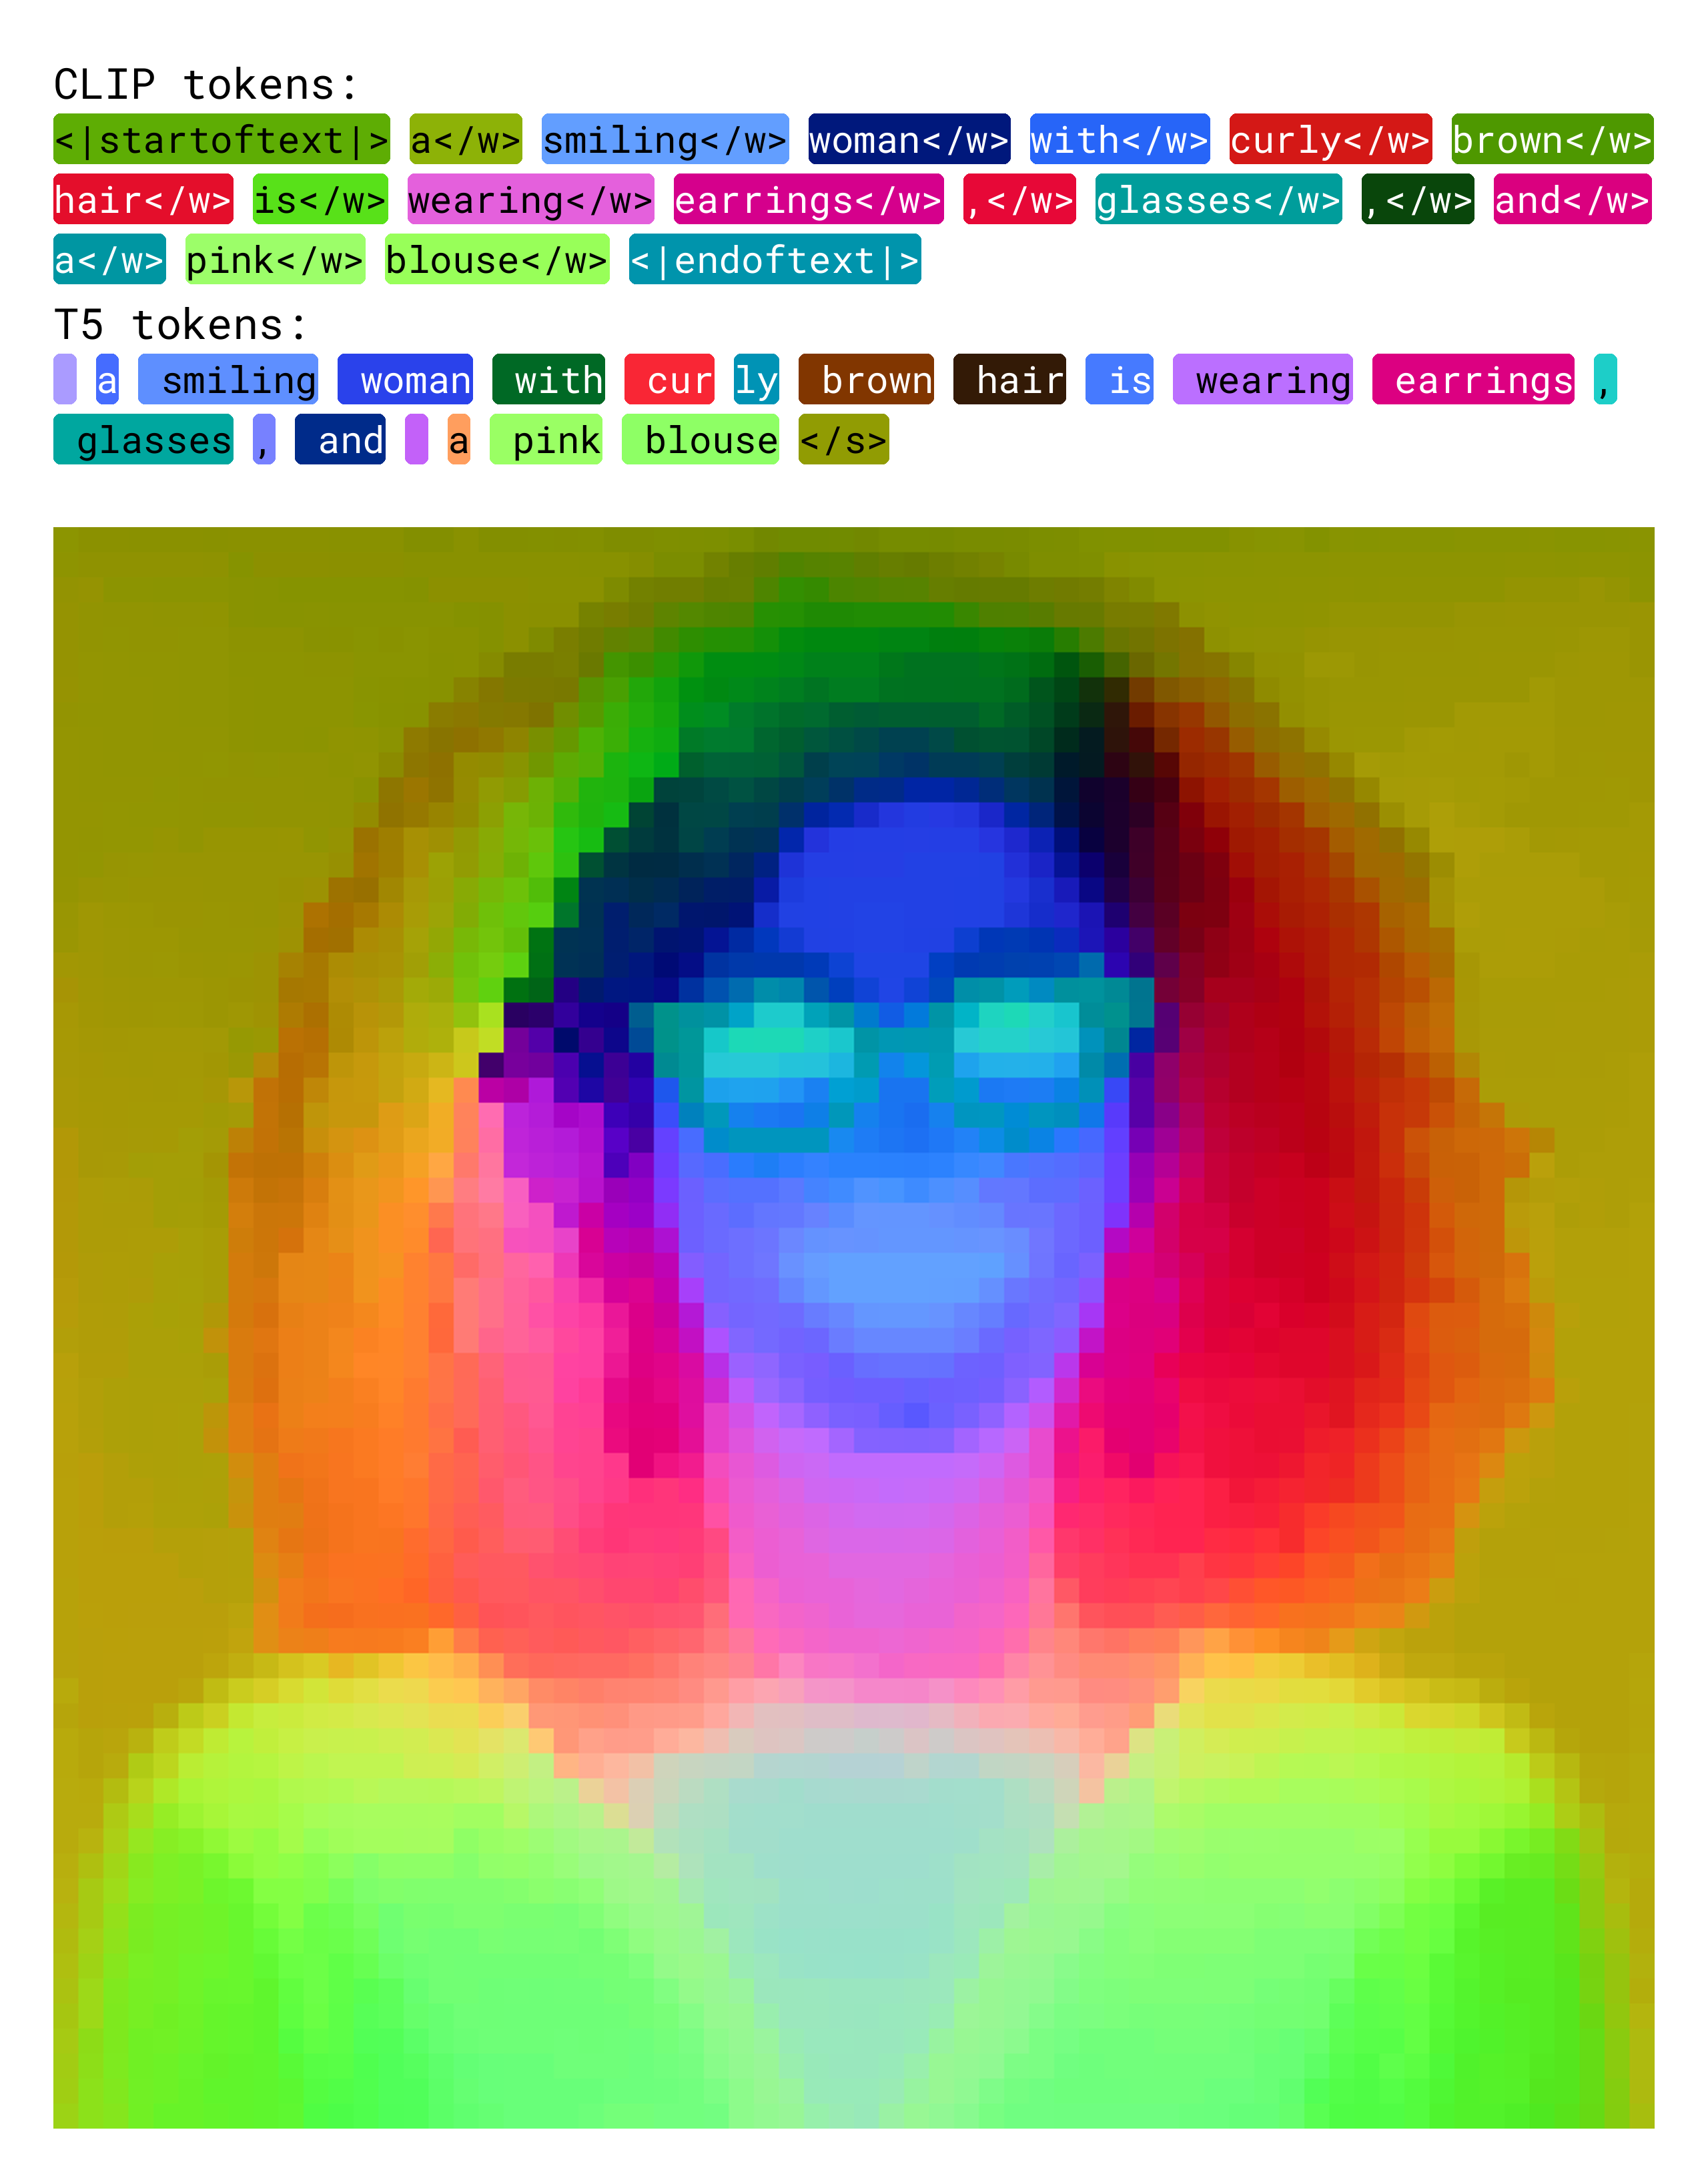

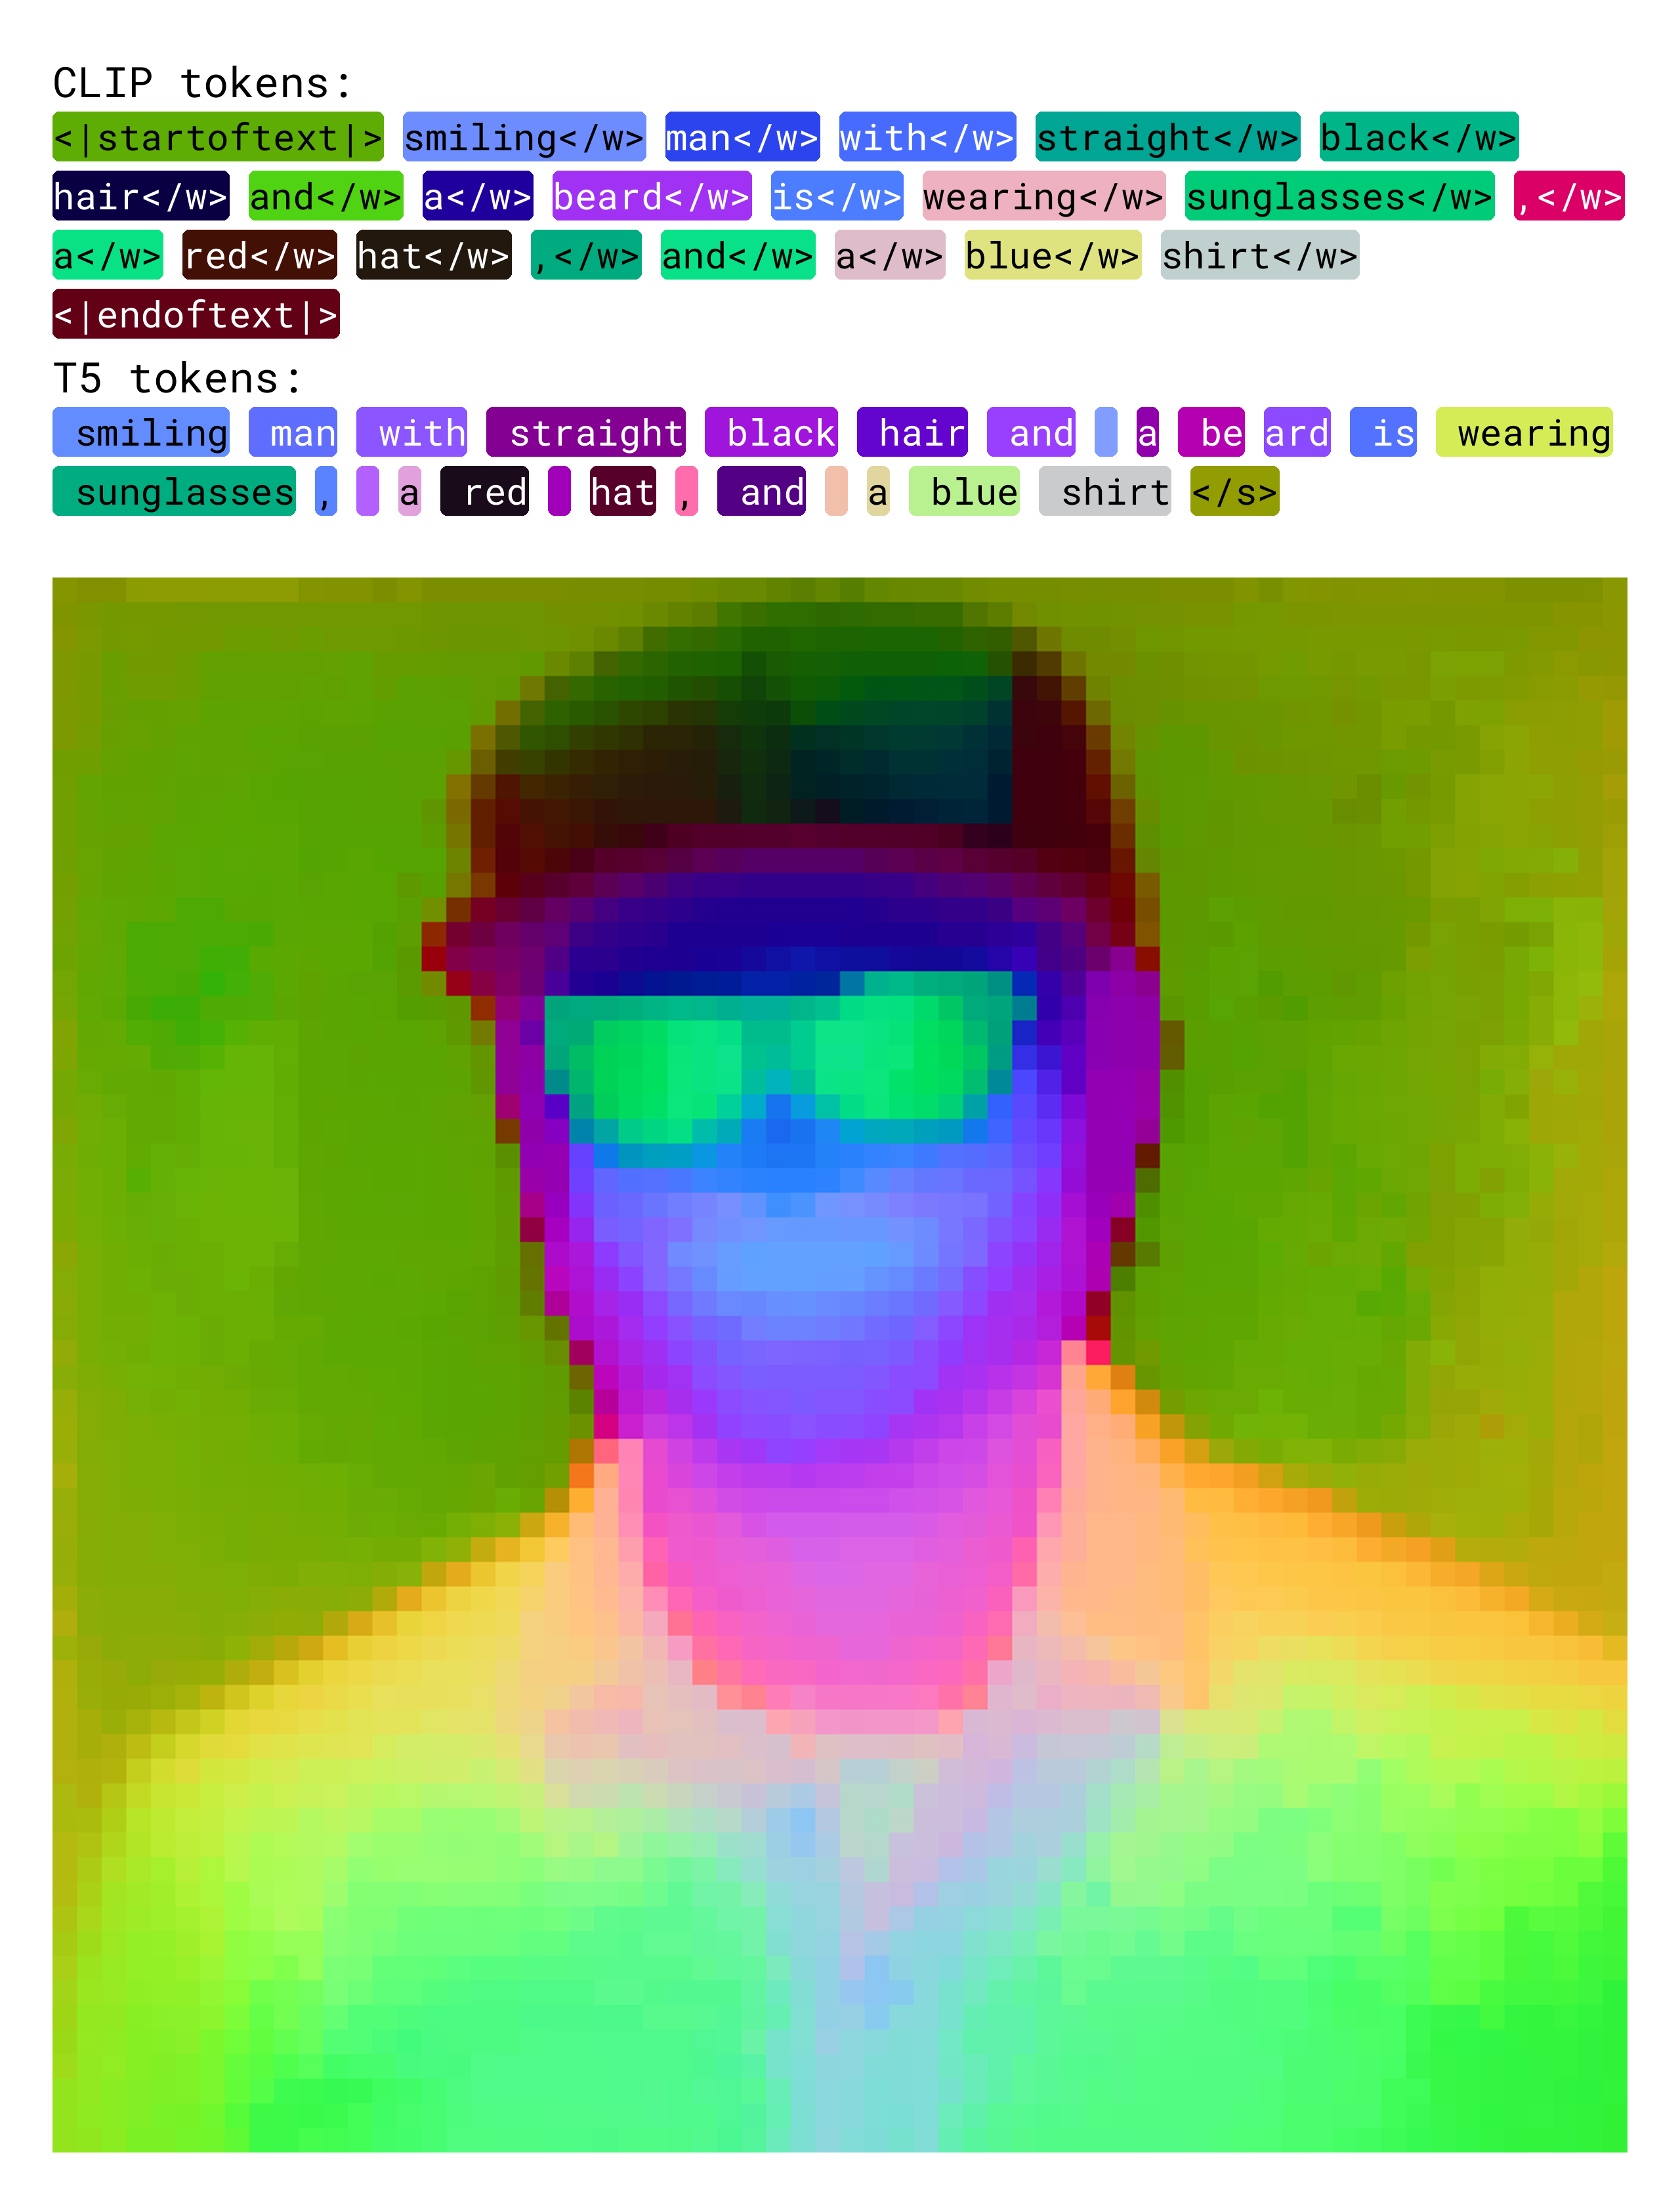

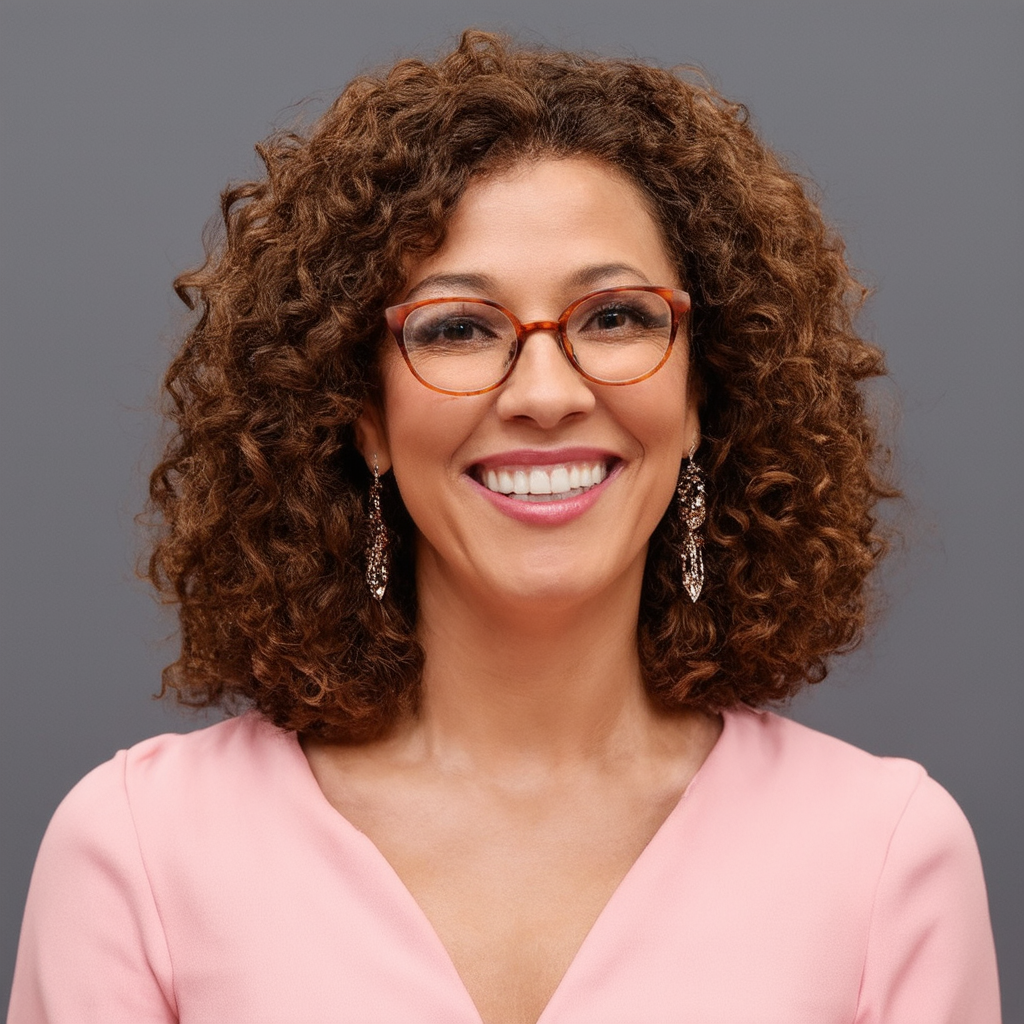

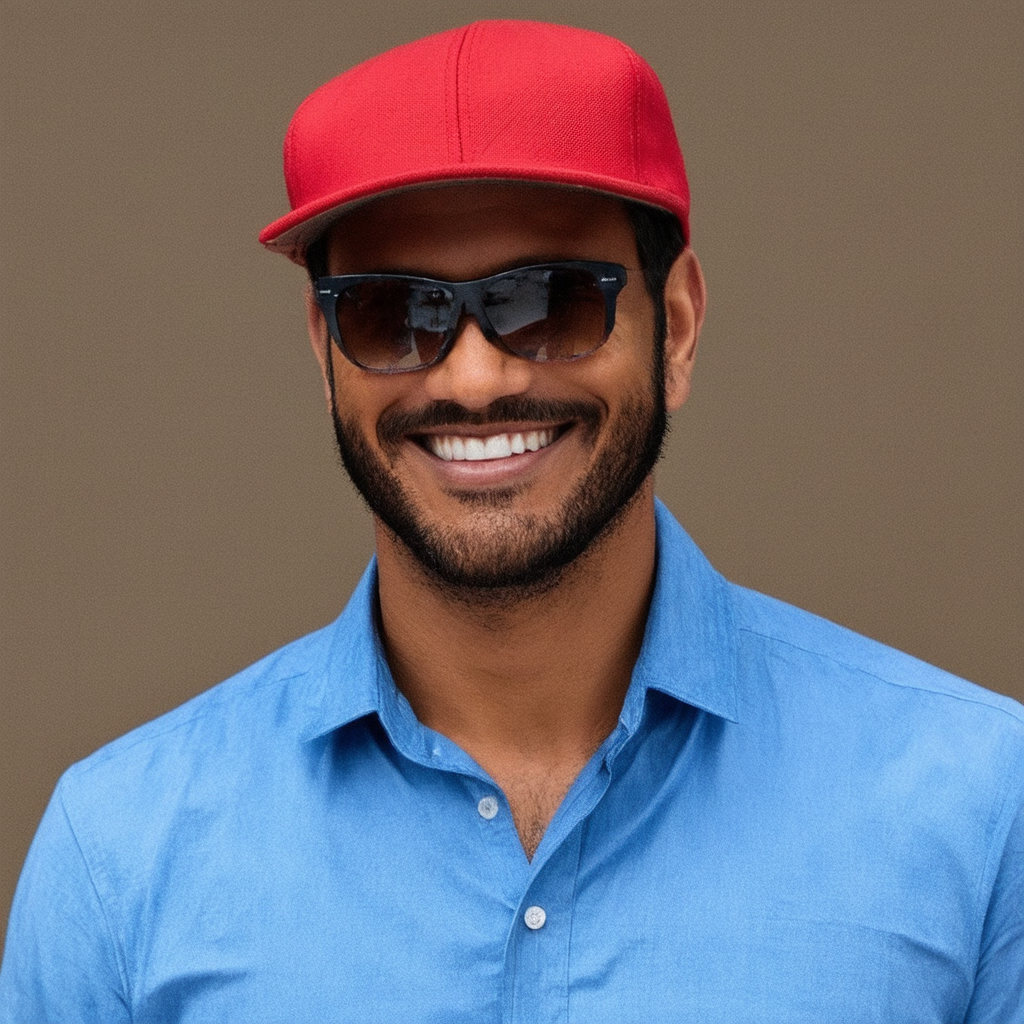

In [7]:
prompts = [
    "a smiling woman with curly brown hair is wearing earrings, glasses, and a pink blouse",
    "smiling man with straight black hair and a beard is wearing sunglasses, a red hat, and a blue shirt",
]

ncut_colors, generated_images = get_ncut_colors_and_generated_images(
    pipeline,
    inference_step=23,
    transformer_blocks=list(range(7, 21)),
    prompts=prompts,
    num_inference_steps=28,
    guidance_scale=3.0,
    random_seed=42,
    num_eigenvectors=39,
)

for prompt, image_ncut_colors in zip(prompts, ncut_colors):
    display(visualize_ncut_colors(pipeline, prompt, image_ncut_colors))

for image in generated_images:
    display(image)